In [1]:
import math
import collections
import pickle
import random
import scipy
import json

from matplotlib import pyplot as plt

import GPy
import numpy as np
import pandas as pd
from tqdm import tqdm


In [2]:
Output = pd.read_excel('Titer_OD.xlsx')
Output['Production Condition'].unique()

array(['Exp0', 'Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5', 'Exp6', 'Exp7',
       'Exp8', 'Exp9', 'Exp10', 'BMGY, BMMY + Cells'], dtype=object)

In [3]:
main_file_path = '/Users/harini/Dropbox (MIT)/Harini Narayanan’s files/1_Home/Biotech/MediaOptimization/BO_MediaOptimization/Molecules/HSA/HSA_TL_Additives_V2/'
carbon_source_filepath = '/Users/harini/Dropbox (MIT)/Harini Narayanan’s files/1_Home/Biotech/MediaOptimization/BO_MediaOptimization/Molecules/'

In [4]:
initN = Output.shape[0]

Titer = []
Prod_OD = []
OG_OD = []
Spec_prod = []
Conditions = []
names_all = Output['Production Condition'].unique()

for name in names_all:
    
    temp1 = Output['Titer'].loc[Output ['Production Condition'] == name].mean()
    temp2 = Output['OD_Prod'].loc[Output ['Production Condition'] == name].mean()
    temp3 = Output['OD_OG'].loc[Output ['Production Condition'] == name].mean()
    temp4 = (Output['Titer'].loc[Output ['Production Condition'] == name]/Output['OD_Prod'].loc[Output ['Production Condition'] == name]).mean()
    Conditions.append(name)
    
    Titer.append(temp1)
    Prod_OD.append(temp2)
    OG_OD.append(temp3)
    Spec_prod.append(temp4)

Data = {'Condition': Conditions, 'Titer': Titer, 
         'Specific Productivity': Spec_prod, 'Prod_OD': Prod_OD, 'OG_OD': OG_OD}


Round1_summary = pd.DataFrame(Data)

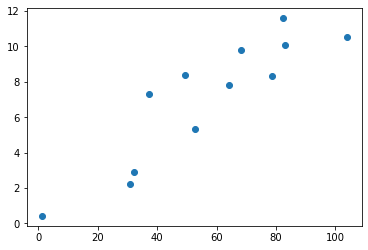

In [5]:
plt.scatter(Titer, Spec_prod)

In [6]:
Round1_summary

,Condition,Titer,Specific Productivity,Prod_OD,OG_OD
0,Exp0,37.253164,7.320347,5.075625,2.913750
1,Exp1,52.849031,5.306958,9.967500,3.701250
2,Exp2,49.221512,8.366431,5.865625,2.452500
3,Exp3,78.664980,8.294714,9.486875,2.348750
4,Exp4,83.072113,10.077039,8.245000,3.827500
5,Exp5,30.871205,2.229433,13.839375,1.443750
6,Exp6,68.243038,9.755601,7.003750,3.168125
7,Exp7,82.510007,11.574839,7.127500,2.207500
8,Exp8,103.740585,10.490688,9.907500,3.130000
9,Exp9,64.047118,7.829217,8.195625,3.013125


In [7]:
Round1_summary.to_csv('Round3_Result_Summary_final.csv')

In [8]:
Exp_1_pd = pd.read_csv(main_file_path + 'Codes/Round3/Reconstructed_Round3.csv')

Exp_1 = Exp_1_pd.iloc[:,1:].values

initN = len(Output['Production Condition'].unique().tolist())-1

In [9]:
initN

11

Converts design space into familiar units e.g., g/L, %, mM etc

In [10]:
Stock_solid = pd.read_excel(carbon_source_filepath+'CarbonSourceInfo.xlsx', 'Stocks_solid')
Stock_liquid = pd.read_excel(carbon_source_filepath +'CarbonSourceInfo.xlsx', 'Stocks_liquid')

Carbon_Names = Stock_solid['Carbon Source'].values.tolist()
Carbon_Names.append(Stock_liquid['Carbon Source'][1])
Carbon_Names.append(Stock_liquid['Carbon Source'][2])


Carbon_Ub = [50]*17 #[g/L]
Carbon_Ub.append(10) # Glycerol [mL/L]
Carbon_Ub.append(50) #Ethanol [mL/L]

OG_Gly_Ub = 100 #[mL/L]
Met_Ub = 100 #[mL/L]


Glu_Ub = 50 #mM
Tween_Ub = 1# 1%
pH_Ub = 6.5# 5X

Glu_Stock_Conc = 250 #mM
Tween_Stock_Conc = 50# 1%
pH_Stock_Conc = 1# 

Stock_Conc = Stock_solid['g/mL'].values.tolist()
Stock_Conc.append(Stock_liquid['mL/mL'][1].tolist())
Stock_Conc.append(Stock_liquid['mL/mL'][2].tolist())

OG_Stock_Conc = Stock_liquid['mL/mL'][0].tolist()


Selected_Carbon = []
Carbon_mL = []
OG_Gly_mL = []
Met_mL = []

Glu_OG_mL = []
Tween_OG_mL = []
Glu_Prod_mL = []
Tween_Prod_mL = []
pH_mL = []

for i in range(initN):
    name = names_all[i]
    temp1 = Output['Titer'].loc[Output ['Production Condition'] == name].to_list()
    Selected_Carbon = Selected_Carbon + [Carbon_Names[int(Exp_1[i,0])]] #* len(temp1)
    
    temp_factor = Carbon_Ub[int(Exp_1[i,0])]
    temp = Exp_1[i,1] * temp_factor # (g/L)
    
    Carbon_mL = Carbon_mL + [temp] #* len(temp1)
    
    OG_Gly_mL = OG_Gly_mL + [Exp_1[i,2] * OG_Gly_Ub * 100/1000] #* len(temp1)  #(%)
    
    Met_mL = Met_mL + [Exp_1[i,3] * Met_Ub * 100/1000] #* len(temp1) #(%)
    
    Glu_OG_mL = Glu_OG_mL + [Exp_1[i,4] * Glu_Ub] #* len(temp1) # mM
    
    Tween_OG_mL = Tween_OG_mL + [Exp_1[i,5] * Tween_Ub] #* len(temp1) #(%)
    
    Glu_Prod_mL = Glu_Prod_mL + [Exp_1[i,6] * Glu_Ub] #* len(temp1)# mM
    
    Tween_Prod_mL = Tween_Prod_mL + [Exp_1[i,7] * Tween_Ub]  #* len(temp1) #(%)
    
    pH_mL = pH_mL + [Exp_1[i,8] * pH_Ub] #* len(temp1) #* 3/pH_Stock_Conc
    

Experiment_1 = {'Carbon_Type': Selected_Carbon,
               'Conc_Carbon [g/L]': Carbon_mL,
               'Gly_OG [%]': OG_Gly_mL,
               'Met_Prod [%]': Met_mL,
                
               'Glu_OG [mM]' :Glu_OG_mL,
                'Tween_OG [%]':Tween_OG_mL,
                'Glu_Prod [mM]': Glu_Prod_mL ,
                'Tween_Prod [%]': Tween_Prod_mL ,  
                  'pH': pH_mL}

pd.DataFrame(Experiment_1).to_csv('Round3_Design_Summary.csv')